In [1]:
#compute the uDFT by noting DFT.DFT^* = D, a diagonal matrix, and factoring as D = RR^*, so uDFT = R^{-1}.DFT
#alternately, one could use unitary representations and normalization factors \sqrt{d_\rho/|G|}
#the resulting DFT will have signs \pm 1 on the diagonal DFT.DFT^* = S, which can be factored as s = rr^*, so S=RR^*
#again, uDFT = R^{-1}.DFT

In [24]:
#for u in GF(q), we can factor as u=aa^*=aa^q=a^{q+1} in GF(q**2) using gen. z and modular arithmetic
def conj_sqrt(u):
    if u == 0:
        return 0
    z = u.parent().multiplicative_generator()
    k = u.log(z)  # Compute discrete log of u to the base z
    if k % (q+1) != 0:
        raise ValueError("exponent must be divisible by q+1")
    return z ** (k//(q+1))

In [25]:
#compute the uDFT by noting DFT.DFT^* = D, a diagonal matrix, and factoring as D = RR^*, so uDFT = R^{-1}.DFT
def unitary_dft():
    dft_matrix = SGA.dft()
    sign_diag = (dft_matrix*dft_matrix.H).diagonal()
    factor_diag_inv = diagonal_matrix([~conj_sqrt(d) for d in sign_diag])
    return factor_diag_inv*dft_matrix

In [404]:
#parameters and define the symmetric group algebra
n = 5; q = 7
F = GF(q**2)
SGA = SymmetricGroupAlgebra(F,n) # F[S_n], group algebra
assert F.characteristic() > 0, "F must have positive characteristic"
if not (F.is_field() and F.is_finite() and F.order().is_square()):
    raise ValueError("the base ring must be a finite field of square order")
if F.characteristic().divides(SGA.group().cardinality()):
    raise NotImplementedError("not implemented when p|n!; dimension of invariant forms may be greater than one")

In [428]:
#converting the unitary DFT over finite fields to a complex matrix using the root of unity map
U = unitary_dft(); U

120 x 120 dense matrix over Finite Field in z2 of size 7^2 (use the '.str()' method to see the entries)

In [429]:
#check that U is unitary over a finite field. .H is conjugate-transpose
U*U.H == 1

True

In [407]:
#given a multiplicative generator `z` of the finite field, the discrete_log is the exponent of the generator
#the discrete_log of zero is -infinity, which we set to -1 for convenience since all other values are nonnegative
discrete_log = lambda F, x: x.log(F.multiplicative_generator()) if x != 0 else -1

In [408]:
#compute the discrete log of each entry of U
log_U = U.apply_map(lambda x: discrete_log(F,x))

In [430]:
log_U

120 x 120 dense matrix over Integer Ring (use the '.str()' method to see the entries)

In [410]:
"""
plot the discrete log of a matrix valued in a finite field
since log(0) = -infinity, we set this to -1, and color it black

- F is the field
- M is a matrix of discrete log values of elements of F

BUG: this is not working for large splitting fields, when the matrix values are ~7 digits
"""
def plot_discrete_log(F, M, path, title):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap, BoundaryNorm

    cmap = plt.cm.hsv  # Get the HSV colormap
    num_colors = min(F.order(), 256) #for large fields we can't use that many colors, set a cutoff
    new_colors = np.vstack(([0, 0, 0, 1], cmap(np.linspace(0, 1, num_colors))))
    custom_cmap = ListedColormap(new_colors) # create a new custom colormap
    norm = BoundaryNorm([-1] + list(np.linspace(0, F.order()-1, num_colors)), custom_cmap.N) #map -1 to black

    # Plotting the data
    plt.imshow(M, cmap=custom_cmap, norm=norm, interpolation="nearest")
    plt.title(title, fontsize=16)
    plt.colorbar()
    plot_title = path + title.replace(' ','_') + '.png'
    plt.savefig(plot_title, dpi=300, bbox_inches="tight")
    plt.show()

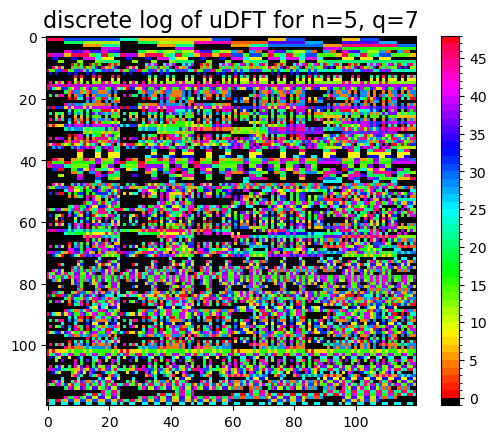

In [411]:
plot_discrete_log(F,log_U,path='plots/dft_matrix/',title=f"discrete log of uDFT for n={n} q={q}")

In [412]:
#the map from modular representation theory to compute Brauer characters from F_q --> \C giving roots of unity
#note: Brauer character is the rep'n matrix eigenvalues (over a splitting field extension of F_q) mapped to \C using Brauer map and summed
#i.e. let \alpha = g^k |--> \exp(2*pi*i*k/(q-1))
#i.e. F_q^* is cyclic of order q-1, mapping to (q-1)^th roots of unity in \C
#if the discrete log is provided, we use it directly; otherwise, we compute it
def brauer_map(F, a=None, log_a=None):
    """
    Map from F_q to C using the Brauer character formula.
    If `log_a` is provided, it uses that directly; otherwise, it computes the log.
    
    a: Element of F_q or None if log_a is given
    log_a: Precomputed log value (optional)
    F: Finite field F_q
    
    Returns: Complex value of the Brauer character
    """
    if a is None and log_a is None:
        raise ValueError("Either 'a' or 'log_a' must be provided.")
    
    if a is not None:
        if a == 0:
            return 0
        log_a = a.log(F.multiplicative_generator())
    
    return exp(2 * pi * I * log_a / (F.order() - 1))

In [413]:
#complexify the uDFT matrix over F_q using the Brauer map
U_complex = matrix(CC,U.apply_map(lambda a: brauer_map(F,a)))

In [414]:
#compute the Gram matrix, taking inner products of rows and columns w.r.t conjugate inner product
#note: want this to be the identity matrix (so it would be unitary over \C), but currently it is not quite
#unitary matrices are required if they are to be used as operators in quantum computing
gram = U_complex*U_complex.H

In [415]:
#function to round each component of a complex number 
def round_complex(z, digits):
    if z.imag_part():
        return round(z.real_part(), digits) + round(z.imag_part(), digits) * I
    return round(z, digits)

In [416]:
#round the (complex) Gram matrix to three decimal places
gram_rounded = gram.apply_map(lambda u:round_complex(u,3))

In [417]:
#plot the complexified version of the uDFT matrix over a finite field
def plot_arg_complex(U_complex, title):
    U_arg = U_complex.apply_map(lambda x: arg(x))  # find the argument of each element
    plot = matrix_plot(U_arg, cmap='hsv', colorbar=True, title=title)  # plot the matrix
    filename = "plots/dft_matrix/" + title.replace(" ", "_") + ".png"
    plot.save(filename, dpi=300)  # Save the plot as a PNG file with high resolution
    return plot

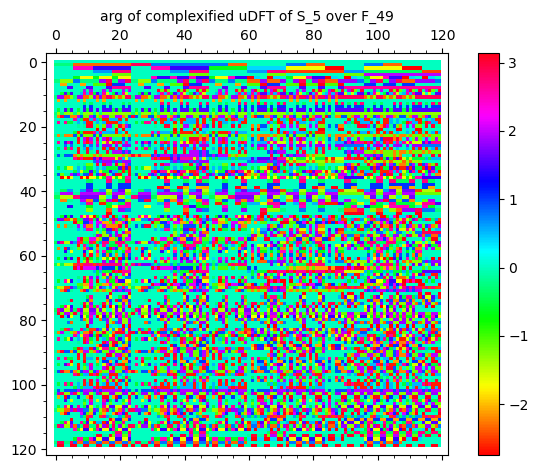

In [418]:
#plot the complexified version of the uDFT matrix over a finite field
plot_arg_complex(U_complex,title=f"arg of complexified uDFT of S_{n} over F_{q**2}")

In [419]:
#check that Gram matrix is conjugate symmetric (should be since it is U*U.H)
gram_rounded == gram_rounded.H

True

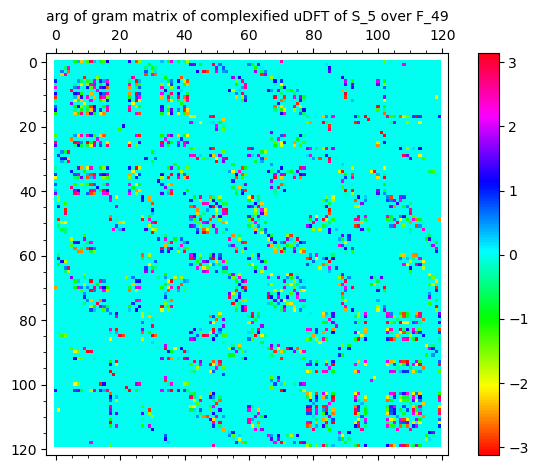

In [420]:
#plot the result of U_complex*U_complex.H to see how far it is from being unitary over the complex numbers
plot_arg_complex(gram_rounded, title=f"arg of gram matrix of complexified uDFT of S_{n} over F_{q**2}")

In [421]:
#compute the eigenvalues of the uDFT matrix
eigenvalues = U.eigenvalues(); eigenvalues

[5*z44^43 + 6*z44^42 + 6*z44^41 + 5*z44^40 + 3*z44^39 + 6*z44^38 + 3*z44^37 + 2*z44^36 + 6*z44^35 + 5*z44^34 + 4*z44^33 + 5*z44^32 + 4*z44^31 + z44^30 + z44^27 + 4*z44^25 + 4*z44^24 + z44^22 + 5*z44^21 + z44^19 + 5*z44^17 + z44^16 + 2*z44^14 + 4*z44^13 + 6*z44^11 + 3*z44^10 + z44^9 + 2*z44^8 + 6*z44^7 + 4*z44^6 + 2*z44^5 + 5*z44^4 + z44^2 + 2*z44 + 1, 2*z44^43 + 4*z44^42 + z44^41 + 5*z44^40 + 2*z44^39 + z44^38 + 2*z44^37 + 2*z44^36 + 3*z44^35 + 5*z44^34 + 4*z44^32 + 4*z44^31 + z44^30 + z44^29 + z44^28 + 5*z44^27 + 4*z44^26 + 3*z44^25 + z44^24 + 4*z44^23 + z44^22 + 6*z44^20 + z44^19 + 4*z44^18 + 3*z44^17 + 2*z44^16 + 6*z44^13 + 2*z44^12 + 4*z44^11 + 3*z44^10 + 2*z44^9 + 3*z44^8 + 2*z44^7 + 2*z44^6 + 2*z44^5 + 2*z44^4 + 4*z44^3 + 4*z44^2 + 2*z44 + 1, 2*z44^43 + 2*z44^42 + 5*z44^41 + 2*z44^40 + z44^39 + 5*z44^37 + 4*z44^36 + z44^35 + z44^34 + 2*z44^33 + 6*z44^32 + 6*z44^31 + 4*z44^30 + 2*z44^29 + 2*z44^28 + 2*z44^27 + 2*z44^26 + 6*z44^25 + 3*z44^24 + z44^23 + 2*z44^22 + 3*z44^21 + z44^20 

In [423]:
#compute the maximum degree required for the eigenvalues
#this should agree with the splitting field degree, but sometimes it doesn't
max_deg_eigs = max([eig.minpoly().degree() for eig in eigenvalues]); max_deg_eigs

76

In [424]:
#compute the multiplicity of each eigenvalue. check if all eigenvalues are distinct
from collections import Counter
multiplicities = Counter(eigenvalues)
all_unique = all(count == 1 for count in multiplicities.values()); all_unique

True

In [425]:
#compute the charpoly of the uDFT matrix 
charpoly = U.minimal_polynomial(); charpoly

x^120 + 5*z2*x^119 + (5*z2 + 5)*x^118 + (6*z2 + 1)*x^117 + (6*z2 + 2)*x^116 + (5*z2 + 5)*x^115 + (5*z2 + 4)*x^114 + (4*z2 + 6)*x^113 + (3*z2 + 5)*x^112 + 5*z2*x^111 + (4*z2 + 5)*x^110 + 3*z2*x^109 + (6*z2 + 3)*x^108 + (3*z2 + 3)*x^107 + z2*x^106 + (z2 + 3)*x^105 + (5*z2 + 1)*x^104 + (z2 + 2)*x^103 + (4*z2 + 2)*x^102 + 3*z2*x^101 + (z2 + 3)*x^100 + 6*z2*x^99 + (5*z2 + 1)*x^98 + (5*z2 + 4)*x^97 + (z2 + 5)*x^96 + (4*z2 + 4)*x^95 + (5*z2 + 6)*x^94 + (3*z2 + 5)*x^93 + 4*z2*x^92 + (4*z2 + 6)*x^91 + 4*z2*x^90 + 3*z2*x^89 + 5*z2*x^88 + (4*z2 + 5)*x^87 + 5*x^86 + (6*z2 + 6)*x^85 + (5*z2 + 6)*x^84 + (6*z2 + 5)*x^83 + x^82 + (6*z2 + 2)*x^81 + (3*z2 + 3)*x^80 + (5*z2 + 6)*x^79 + (5*z2 + 2)*x^78 + (z2 + 5)*x^77 + (5*z2 + 2)*x^76 + 2*z2*x^75 + (4*z2 + 5)*x^74 + (4*z2 + 5)*x^73 + (4*z2 + 5)*x^72 + (z2 + 5)*x^71 + (5*z2 + 1)*x^70 + x^69 + (2*z2 + 1)*x^68 + (4*z2 + 5)*x^67 + (6*z2 + 5)*x^66 + 2*z2*x^65 + (z2 + 5)*x^64 + (6*z2 + 4)*x^63 + (6*z2 + 1)*x^62 + (4*z2 + 5)*x^61 + (2*z2 + 6)*x^60 + (4*z2 + 5)*

In [426]:
#compute a splitting field of the characteristic polynomial
K = GF(q**max_deg_eigs); print(f"field containing all eigenvalues: K = {K}")
L = charpoly.splitting_field('a'); print(f"splitting field: L = {L}")
print(K.multiplicative_generator().minimal_polynomial())

field containing all eigenvalues: K = Finite Field in z76 of size 7^76
splitting field: L = Finite Field in a of size 7^836
x^76 + 5*x^75 + 4*x^72 + x^71 + 5*x^69 + 2*x^68 + 5*x^66 + 6*x^65 + 5*x^64 + 6*x^62 + x^61 + 6*x^60 + 2*x^59 + 3*x^57 + x^56 + 3*x^55 + x^54 + 3*x^53 + 6*x^52 + 3*x^51 + 4*x^50 + 2*x^49 + 5*x^47 + 5*x^46 + 4*x^45 + x^44 + 6*x^43 + 4*x^41 + 3*x^40 + x^39 + 6*x^38 + 6*x^37 + 6*x^36 + 4*x^35 + 6*x^33 + 4*x^32 + x^31 + x^30 + x^29 + 3*x^26 + x^24 + 5*x^23 + 3*x^22 + 2*x^20 + 6*x^19 + 4*x^18 + 4*x^17 + 5*x^16 + 6*x^15 + 5*x^14 + 3*x^13 + 2*x^12 + 5*x^11 + 3*x^10 + 3*x^9 + 5*x^8 + x^7 + 5*x^6 + 6*x^5 + 4*x^4 + x^3 + 4*x^2 + x + 3


In [401]:
def save_array(array, path, filename):
    """
    save an array as a comma separated value file by converting the elements to strings
    """
    import os
    if not os.path.exists(path):
        os.makedirs(path)  # Create the directory if it doesn't exist
    full_path = os.path.join(path, filename)
    with open(full_path, 'w') as f:
        for i, element in enumerate(array):
            f.write(str(element))
            if i < len(array) - 1:
                f.write(",")
        f.write("\n")

In [427]:
#compute the eigenvalues over a specific field K, L rather than using the algebraic closure
eigenvalues_K = matrix(K,U).eigenvalues(extend=False)
eigenvalues_L = matrix(L,U).eigenvalues(extend=False)

KeyboardInterrupt: 

In [403]:
#save the eigenvalues over K, L
save_array(eigenvalues_K, path='data/', filename=f"eigenvalues_uDFT_n={n}_q={q}_deg={K.degree()}" + '.csv')
save_array(eigenvalues_L, path='data/', filename=f"eigenvalues_uDFT_n={n}_q={q}_deg={L.degree()}" + '.csv')

In [349]:
#compute the discrete log of the eigenvalues over K
log_eigenvalues_K = list(map(lambda x: discrete_log(K,x), eigenvalues_K))
log_eigenvalues_L = list(map(lambda x: discrete_log(L,x), eigenvalues_L))

eigenvalues_K= [11269670145346129043931624, 19569211138526239672164486, 20790904065162128909891334, 6379196630969910098252790, 424304164595145487956966, 14087087681682661304914530, 14785335754071908710154310, 13690777798835597759922054, 3222562647371267985937254, 16861256861612106119861862, 17207243712868805688146454, 22520742049785640274165718, 21628026486267985216684278, 12239053578710904245803398, 4483986111792702630829206, 130187686346324695882710, 9199351174957929468236070]
eigenvalues_L= [1477605188168378790144200123776978890472013290343642872741298573911351537949742284105634710483896861269091064486692417490175363104656963999043545080602313621618016271111928177624, 1888147562025678170924869153631064648855589872825296539781763897546882624943889810503635196085253126639427489755514741738098929889376648526409596938381738878367076444084771107560, 13972139832348183630103665614623227989516247454945095721200169962644289420015569029512129503409711371518576982011917980968145048740610934154

In [368]:
#save the discrete logs of eigenvalues over K, L
save_array(log_eigenvalues_K, path='data/', filename=f"discrete_log_eigenvalues_uDFT_n={n}_q={q}_deg={K.degree()}" + '.csv')
save_array(log_eigenvalues_L, path='data/', filename=f"discrete_log_eigenvalues_uDFT_n={n}_q={q}_deg={L.degree()}" + '.csv')

In [398]:
#compute the complexified eigenvalue over K, L
complexified_eigenvalues_K = [brauer_map(K,log_a=log_eig) for log_eig in log_eigenvalues_K]
complexified_eigenvalues_L = [brauer_map(L,log_a=log_eig) for log_eig in log_eigenvalues_L]

In [400]:
#save the discrete logs of eigenvalues over K, L
save_array(complexified_eigenvalues_K, path='data/', filename=f"complexified_eigenvalues_uDFT_n={n}_q={q}_deg={K.degree()}" + '.csv')
save_array(complexified_eigenvalues_L, path='data/', filename=f"complexified_eigenvalues_uDFT_n={n}_q={q}_deg={L.degree()}" + '.csv')

In [399]:
import matplotlib.pyplot as plt
import numpy as np

# Extract real and imaginary parts for plotting
real_parts = [eig.real() for eig in complexified_eigenvalues_L]
imaginary_parts = [eig.imag() for eig in complexified_eigenvalues_L]

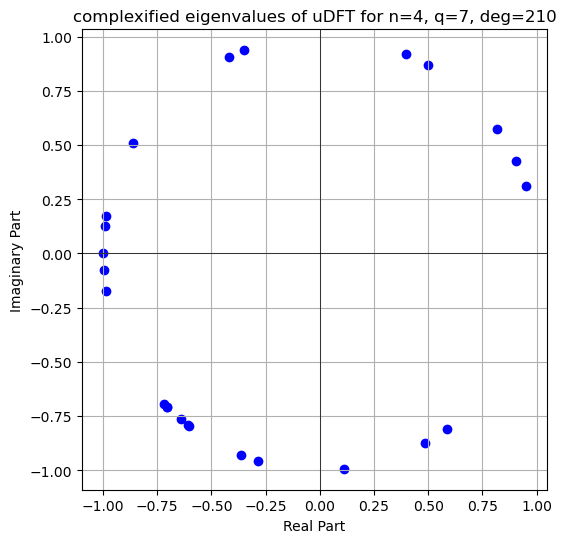

In [396]:
# Plotting the eigenvalues on the complex plane
title = f"complexified eigenvalues of uDFT for n={n}, q={q}, deg={L.degree()}"
plt.figure(figsize=(6,6))
plt.scatter(real_parts, imaginary_parts, color='blue', label="Eigenvalues")
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(title)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.savefig('plots/eigenvalues/finite_fields/' + title.replace(' ','_') + '.png', dpi=300, bbox_inches="tight")
plt.show()

In [320]:
#compute the eigenvectors over a splitting field
D, P = matrix(L,U).eigenmatrix_right()

In [321]:
def write_matrix_to_csv(P,filename):
    """
    dump the eigenvector matrix into a .csv file
    """
    with open(filename, "w") as f:
        for row in P:
            f.write(",".join(map(str, row)) + "\n")

In [322]:
write_matrix_to_csv(P,filename=f"data/eigenvectors_unitary_dft_symmetric_group_finite_field_n={n}_q={q}.csv")

In [323]:
#take the discrete log of the eigenvector matrix
log_P = P.apply_map(lambda x: discrete_log(L,x)); log_P

[                0                 0                 0                 0                 0                 0]
[22689761797238269 20702645593902589 12772541917661592 13523245755449361  3495018369229650 11976932273987601]
[11727754551588639  6978876427228959 21002152480419206  1362287283069904 15409676675944734 20973400951923664]
[14579426119294872  7816719458901912  1589044626709508 20061842302069898  3404489112688662  3103075099765898]
[ 5077809292629124  7357597852275844 17981569188489612 11347564654638395  2911937431490442 19959385578951995]
[16327908218895593  5293676504325353 12706162947981234 10976243789732849  6310175695144002  3732098528082929]

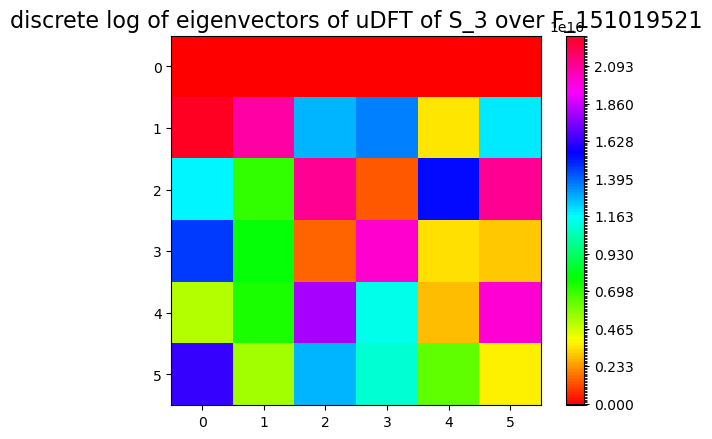

In [324]:
#plot the discrete log of the eigenvector matrix P
plot_discrete_log(L,log_P,path='plots/eigenvectors/',title=f"discrete log of eigenvectors of uDFT of S_{n} over F_{q**2}")

In [270]:
def dump_discrete_log(L, P):
    """
    - compute the discrete log of each entry of P, the eigenvector matrix of the uDFT of S_n over F_{q^2}
    - write the resulting matrix to a comma separated value file
    - include a progress bar since computing discrete logs for large fields takes a long time
    """
    total = P.nrows() * P.ncols()
    count = 0
    filename = f"data/discrete_log_dft_symmetric_group_finite_field_eigenvector_matrix_n={n}_q={q}.csv"
    with open(filename, "w") as f:
        for i in range(P.nrows()):
            for j in range(P.ncols()):
                log_value = discrete_log(L, P[i, j])
                f.write(str(log_value))
                if j != P.ncols()-1:
                    f.write(",")
                count += 1
                # Print progress as a percentage
                progress = float(count) / total * 100
                print(f"Progress: {progress:.2f}%\n", end="")
            f.write("\n")
    return "done"

In [271]:
dump_discrete_log(L, P)

Progress: 2.78%
Progress: 5.56%
Progress: 8.33%
Progress: 11.11%
Progress: 13.89%
Progress: 16.67%
Progress: 19.44%
Progress: 22.22%
Progress: 25.00%
Progress: 27.78%
Progress: 30.56%
Progress: 33.33%
Progress: 36.11%
Progress: 38.89%
Progress: 41.67%
Progress: 44.44%
Progress: 47.22%
Progress: 50.00%
Progress: 52.78%
Progress: 55.56%
Progress: 58.33%
Progress: 61.11%
Progress: 63.89%
Progress: 66.67%
Progress: 69.44%
Progress: 72.22%
Progress: 75.00%
Progress: 77.78%
Progress: 80.56%
Progress: 83.33%
Progress: 86.11%
Progress: 88.89%
Progress: 91.67%
Progress: 94.44%
Progress: 97.22%
Progress: 100.00%


'done'